In [1]:
import os
import sys

# 프로젝트 루트 경로를 sys.path에 추가 (상위 폴더의 모듈을 import하기 위함)
sys.path.append(os.path.dirname(os.getcwd()))

from openai import OpenAI
from dotenv import load_dotenv
from utils.langsmith import langsmith  # langsmith 함수 import

langsmith("text2sql")


In [2]:
import requests
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db","wb") as f:
        f.write(response.content)
    print("Chinook.db 파일이 성공적으로 다운로드되었습니다.")
else:
    print(f"Failed to download Chinook.db: {response.status_code}")

Chinook.db 파일이 성공적으로 다운로드되었습니다.


In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

print(f"db dialect: {db.dialect}")

print(f"db table names: {db.get_usable_table_names()}")

db.run('SELECT * FROM Artist LIMIT 10')

db dialect: sqlite
db table names: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [4]:
from typing import Any
from langchain_core.messages import ToolMessage 
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


# 오류처리함수
def handle_tool_error(state) -> dict:
    # 오류 정보 조회
    error = state.get("error")
    # 도구 정보 조회
    tool_calls = state.messages[-1].tool_calls 
    # ToolMessage 로 래핑 후 반환
    return {
        "messages" : [
            ToolMessage(
                content=f"Here is the error: {repr(error)}\n\nPlease fix your mistakes.",
                tool_call_id=tc["id"]
            )
            for tc in tool_calls 
        ]
    }

# 오류를 처리하고 에이전트에 오류를 전달하기 위한 ToolNode 생성
# ToolNode를 오류 처리 와 에이전트에 오류를 전달하는 기능 을 포함하여 래핑
def create_tool_node_with_fallback(tools:list) -> RunnableWithFallbacks[Any, dict]:
    """ 도구 노드를 생성하고 오류 처리 기능을 추가한 실행 가능한 객체 반환 """
    # 오류 발생 시 대체 동작을 정의하여 ToolNode에 추가
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


/Users/odueon/Desktop/work/LLM-playground/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SQL 쿼리 실행 도구
에이전트가 데이터베이스와 상호작용할 수 있도록 몇 가지 도구를 정의합니다.    
  
1. list_tables_tool: 데이터베이스에서 사용 가능한 테이블을 가져옵니다.  
2. get_schema_tool: 테이블의 DDL을 가져옵니다.  
3. db_query_tool: 쿼리를 실행하고 결과를 가져오거나 쿼리가 실패할 경우 오류 메시지를 반환합니다.  

**참고**
* DDL(데이터 정의 언어, Data Definition Language)은 데이터베이스의 구조와 스키마를 정의하거나 수정하는 데 사용되는 SQL 명령어들을 지칭합니다. 
* 주로 테이블, 인덱스, 뷰, 스키마 등의 데이터베이스 객체를 생성, 수정, 삭제할 때 사용됩니다.

주요 DDL 명령어

* CREATE: 데이터베이스 객체를 생성합니다.
    예: CREATE TABLE users (id INT, name VARCHAR(100));
* ALTER: 기존 데이터베이스 객체를 수정합니다.
    예: ALTER TABLE users ADD COLUMN email VARCHAR(100);
* DROP: 데이터베이스 객체를 삭제합니다.
    예: DROP TABLE users;

### 데이터베이스 쿼리 관련 도구
다음은 SQL database와 상호작용하기 위한 SQLDatabaseToolkit 도구 목록입니다.

**QuerySQLDataBaseTool**

* 기능: SQL query 실행 및 결과 반환
* Input: 정확한 SQL query
* Output: Database 결과 또는 error message
* Error 처리:
    * Query 오류 발생 시 재작성 및 재시도
    * Unknown column 오류 시 sql_db_schema로 정확한 table fields 확인
**InfoSQLDatabaseTool**
* 기능: Table schema 및 sample data 조회
* Input: 콤마로 구분된 table 목록
* 사용 예시: table1, table2, table3
* 주의사항: sql_db_list_tables로 table 존재 여부 사전 확인 필요
**ListSQLDatabaseTool**
* 기능: Database 내 table 목록 조회
**QuerySQLCheckerTool**
* 기능: Query 실행 전 유효성 검사
* 검사 항목:
    * NULL 값과 NOT IN 사용
    * UNION vs UNION ALL 적절성
    * BETWEEN 범위 설정
    * Data type 일치 여부
    * Identifier 인용 적절성
    * Function argument 수
    * Data type casting
    * Join column 정확성
* 특징: GPT-4 model 기반 검증 수행

In [5]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), temperature=0)

# SQLDatabaseToolkit 생성 
toolkit = SQLDatabaseToolkit(db=db, llm=model)

# SQLDatabaseToolkit에서 사용 가능한 도구 목록 
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11238a9f0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11238a9f0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11238a9f0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

In [6]:
# 데이터베이스에서 사용 가능한 테이블을 나열하는 도구 선택 
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# 특정 테이블의 DDL을 가져오는 도구 선택 
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# 데이터베이스의 모든 테이블 목록 출력
print("테이블 목록:")
print(list_tables_tool.invoke(""))

# Artist 테이블의 DDL 정보 출력 
print("DDL 정보:")
print(get_schema_tool.invoke("Artist"))


테이블 목록:
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
DDL 정보:

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [7]:
from langchain_core.tools import tool

@tool 
def db_query_tool(query:str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """

    # 쿼리 실행 
    result = db.run_no_throw(query)

    # 오류: 결과가 없으면 오류 메시지 반환 
    if not result:
        return "Error: No results returned from the query. Please try again."
    # 정상: 결과 반환 
    return result

In [8]:
# 실패 사례
print(db_query_tool.invoke("SELECT * FROM Artist LIMITS 10;"))
print("=="*100)
# 성공 사례
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10"))

Error: (sqlite3.OperationalError) near "10": syntax error
[SQL: SELECT * FROM Artist LIMITS 10;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [9]:
# SQL 쿼리 점검(SQL Query Checker)
# SQL 쿼리에서 일반적인 실수를 점검하기 위해 LLM을 활용

from langchain_core.prompts import ChatPromptTemplate 
from langchain_openai import ChatOpenAI

# 쿼리 점검 프롬프트 템플릿 생성
query_check_system = """ 
    You are a SQL expert with a strong attention to detail. 
    Your task is to check the SQL query for common errors and ensure it is correct.
    Double check the SQLite query for common errors.
    - Using NOT IN with NULL values 
    - Using UNION when UNION ALL should have been used 
    - Using BETWEEN for exclusive ranges 
    - Data type mismatch in predicates 
    - Properly quoting identifiers 
    - Using the correct number of arguments for functions 
    - Casting to the correct data type 
    - Using the proper columns for joins 

    If there  are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query. 
    You will call the appropriate tool to execute the query after running this process. 
"""

# 쿼리 점검 프롬프트 템플릿 생성
query_check_prompt = ChatPromptTemplate.from_messages([
    ("system", query_check_system),
    ("placeholder", "{messages}"),
])

# query checker 체인 생성 
query_check = query_check_prompt | model.bind_tools([db_query_tool], tool_choice="db_query_tool")

In [10]:
# 결과 테스트 
response = query_check.invoke(
    {"messages":[("user", "SELECT * FROM Artist LIMITS 10")]}
)
print(response.tool_calls[0])

{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10'}, 'id': 'call_oo1MBVEg4jy2CBWoAldz0J9l', 'type': 'tool_call'}


In [11]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver


# 에이전트의 상태 정의
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# 새로운 그래프 정의
workflow = StateGraph(State)


# 첫 번째 도구 호출을 위한 노드 추가
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "initial_tool_call_abc123",
                    }
                ],
            )
        ]
    }


# 쿼리의 정확성을 모델로 점검하기 위한 함수 정의
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to check that your query is correct before you run it
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


# 첫 번째 도구 호출 노드 추가
workflow.add_node("first_tool_call", first_tool_call)

# 첫 번째 두 도구를 위한 노드 추가
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node(
    "get_schema_tool", create_tool_node_with_fallback([get_schema_tool])
)

# 질문과 사용 가능한 테이블을 기반으로 관련 테이블을 선택하는 모델 노드 추가 
model_get_schema = model.bind_tools([get_schema_tool])

workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages" : model_get_schema.invoke(state["messages"])
    }
)

# 최종 상태를 나타내는 도구 설명 
class SubmitFinalAnswer(BaseModel):
    """ 쿼리 결과를 기반으로 사용자에게 최종 답변을 제출 """ 
    final_answer: str = Field(..., description="최종 답변")

# 쿼리 생성을 위한 모델 노드 추가 
QUERY_GEN_INSTRUCTION = """ 
    You are a SQL expert with a strong attention to detail.
    You can define SQL queries and analyze queries results and interpretate query results to response an answer. 
    Read the messages bellow and identify the user question, table schemas, query statement and query result, or erorrs if they exist.
    1. If there is not any query result that make sense to answer the question, create a syntactically correct SQLite query to answer the user question. 
    DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP, etc.) to database. 
    2. If you create a query, response ONLY the query statement. For example, "SELECT id, name FROM pets;"
    3. If a query was already executed, but there was an error, response with the same error message you found. For example : "Error: Pets table does not exist."
    4. If a query was already executed successfully interpretate the response and answer the question following this pattern: "Answer : <<question answer>>". 
    - for example : "Answer: There three cats registered as adopted"
"""

query_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", QUERY_GEN_INSTRUCTION),
    ("placeholder", "{messages}"),
])

# SubmitFinalAnswer만 도구로 바인딩 (model_check_query는 노드 함수이므로 제거)
query_gen = query_gen_prompt | model.bind_tools([SubmitFinalAnswer])

# 조건부 엣지 정의 
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    # content 추출 (리스트일 수 있음)
    content = last_message.content
    if isinstance(content, list):
        text_parts = []
        for item in content:
            if isinstance(item, dict) and "text" in item:
                text_parts.append(item["text"])
            elif isinstance(item, str):
                text_parts.append(item)
        content = "".join(text_parts)
    
    # 최종 답변인 경우: END
    if content.startswith("Answer:"):
        return END 
    
    # 에러인 경우: 다시 query_gen으로
    if content.startswith("Error:"):
        return "query_gen"
    
    # 그 외 (SQL 쿼리가 생성된 경우): correct_query로
    return "correct_query"

# 쿼리 생성 노드 정의 
def query_gen_node(state: State): 
    message = query_gen.invoke(state)
    message.pretty_print()

    # tool_calls가 있는 경우 처리
    if message.tool_calls:
        for tc in message.tool_calls: 
            # 최신 LangChain: tool_calls는 dict 형태
            tc_name = tc["name"] if isinstance(tc, dict) else getattr(tc, "name", None)
            tc_args = tc["args"] if isinstance(tc, dict) else getattr(tc, "args", {})
            
            if tc_name == "SubmitFinalAnswer":
                # SubmitFinalAnswer인 경우: 최종 답변을 AIMessage로 반환
                final_answer = tc_args.get("final_answer", "")
                return {"messages": [AIMessage(content=f"Answer: {final_answer}")]}
    
    # tool_calls가 없는 경우 (SQL 쿼리가 생성됨): 메시지만 반환
    # 이 경우 should_continue에서 correct_query로 라우팅됨
    return {"messages": [message]}

# 쿼리 생성 노드 추가 
workflow.add_node("query_gen", query_gen_node)

# 쿼리를 실행하기 전에 모델로 점검하는 노드 추가 
workflow.add_node("correct_query", model_check_query)

# 쿼리를 실행하기 위한 노드 추가 
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# 노드간의 엣지 지정 
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen", 
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# 실행가능한 워크플로우로 컴파일
app = workflow.compile(checkpointer=MemorySaver())

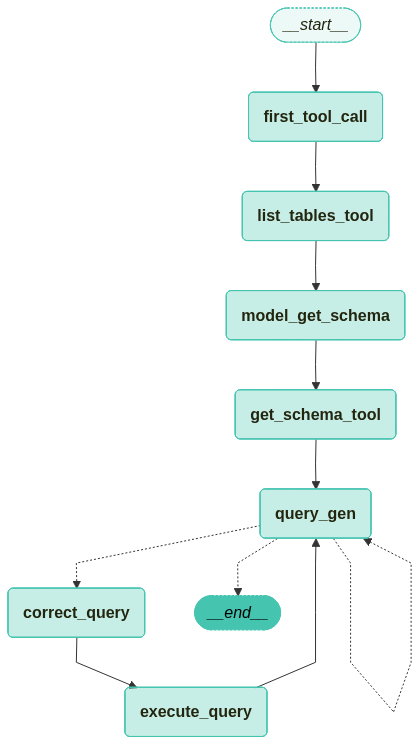

In [12]:
from utils.graphs import visualize_graph
visualize_graph(app, xray=True)

### 그래프 실행 
------

* 에이전트를 실행하여 SQL 데이터베이스와 상호작용하는 전체 프로세스를 진행
* 에이전트는 사용자의 질문에 따라 데이터베이스에서 정보를 검색하고, 쿼리를 생성 및 실행하여 결과를 반환

In [ ]:
from typing import Optional, List, Dict, Any, Literal
from langchain_core.runnables import RunnableConfig 
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError 

from utils.messages import random_uuid, invoke_graph, stream_graph, StreamMode

def run_graph(
    message: str, 
    recursion_limit: int = 10, 
    node_names: Optional[List[str]] = None,
    stream: bool = False,
    stream_mode: StreamMode = "updates",
) -> Optional[Dict[str, Any]]:
    """
    SQL 에이전트 그래프를 실행합니다.
    
    Args:
        message: 사용자 질문
        recursion_limit: 최대 재귀 횟수 (기본: 10)
        node_names: 출력할 노드 이름 목록 (None이면 모든 노드)
        stream: 스트리밍 모드 사용 여부
        stream_mode: 스트리밍 모드 ("messages", "updates", "values")
    
    Returns:
        Optional[Dict[str, Any]]: 그래프 실행 결과
    """
    node_names = node_names or []
    
    # config 설정 (재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursion_limit, 
        configurable={"thread_id": random_uuid()}
    )

    # 질문 입력 
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # 스트리밍 모드로 그래프 실행
            result = stream_graph(
                app, 
                inputs, 
                config, 
                node_names=node_names,
                stream_mode=stream_mode,
            )
        else:
            # 일반 모드로 그래프 실행
            result = invoke_graph(app, inputs, config, node_names=node_names)
        
        return result
        
    except GraphRecursionError as e:
        print(f"Graph recursion error: {e}")
        output = app.get_state(config).values 
        return {"error": str(e), "state": output}

In [14]:

output = run_graph(
    "Andrew Adam 직원의 인적정보를 모두 조회해줘",
    stream=False,
)


🔄 Node: first_tool_call 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (initial_tool_call_abc123)
 Call ID: initial_tool_call_abc123
  Args:

🔄 Node: list_tables_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

🔄 Node: model_get_schema 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_Zw3L7TpkJxU4Rao3p4pd3DQ4)
 Call ID: call_Zw3L7TpkJxU4Rao3p4pd3DQ4
  Args:
    table_names: Employee

🔄 Node: get_schema_tool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

CREATE TABLE "Employee" (
	"EmployeeId" INTEGER NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"FirstName" NVARCHAR(20) NOT NULL, 
	"Title" NVARCHAR(30), 
	"ReportsTo" INTEGER, 
	

##  LangSmith Evaluator 를 활용한 SQL Agent 평가
1. 생성한 Agent 의 SQL 쿼리 응답을 평가. 쿼리 응답을 평가하기 위한 평가용 데이터셋을 생성.
2. 평가자를 정의하고 평가를 진행. 이때 활용하는 평가자는 LLM-as-judge 이며, 사용하는 프롬프트는 기본 hub 에서 제공하는 프롬프트를 활용.

In [15]:
from langsmith import Client

# 클라이언트 초기화
client = Client()

# 데이터셋 생성 및 업로드
examples = [
    (
        "Which country's customers spent the most? And how much did they spend?",
        "The country whose customers spent the most is the USA, with a total spending of 523.06.",
    ),
    (
        "What was the most purchased track of 2013?",
        "The most purchased track of 2013 was Hot Girl.",
    ),
    (
        "How many albums does the artist Led Zeppelin have?",
        "Led Zeppelin has 14 albums",
    ),
    (
        "What is the total price for the album “Big Ones”?",
        "The total price for the album 'Big Ones' is 14.85",
    ),
    (
        "Which sales agent made the most in sales in 2009?",
        "Steve Johnson made the most sales in 2009",
    ),
]

dataset_name = "SQL Agent Response"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

In [16]:
# 에이전트의 SQL 쿼리 응답을 예측하기 위한 함수 정의
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    config = RunnableConfig(configurable={"thread_id": random_uuid()})

    inputs = {
        "messages": [HumanMessage(content=example["input"])],
    }
    # 그래프를 실행하여 메시지 결과 조회
    messages = app.invoke(inputs, config)
    answer = messages["messages"][-1].content
    # 결과 반환
    return {"response": answer}

In [19]:
from langsmith import Client as LangSmithClient

# langsmith의 pull_prompt 사용 (최신 방식)
langsmith_client = LangSmithClient()
grade_prompt_answer_accuracy = langsmith_client.pull_prompt("langchain-ai/rag-answer-vs-reference")


# 답변 평가자 LLM-as-judge 정의
def answer_evaluator(run, example) -> dict:
    # input: 질문
    input_question = example.inputs["input"]
    # output: 참조 답변
    reference = example.outputs["output"]
    # 예측 답변 (에러 발생 시 빈 문자열 반환)
    prediction = run.outputs.get("response", "Error: No response")

    # LLM 평가자 초기화
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))
    answer_grader = grade_prompt_answer_accuracy | llm

    # 평가자 실행
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]

    # 점수 반환
    return {"key": "answer_v_reference_score", "score": score}

In [20]:
from langsmith.evaluation import evaluate

# 평가용 데이터셋 이름
dataset_name = "SQL Agent Response"

try:
    # 평가 진행
    experiment_results = evaluate(
        predict_sql_agent_answer,  # 평가시 활용할 예측 함수
        data=dataset_name,  # 평가용 데이터셋 이름
        evaluators=[answer_evaluator],  # 평가자 목록
        num_repetitions=3,  # 실험 반복 횟수 설정
        experiment_prefix="sql-agent-eval",
        metadata={"version": "chinook db, sql-agent-eval: gpt-4o"},  # 실험 메타데이터
    )
except Exception as e:
    print(e)

View the evaluation results for experiment: 'sql-agent-eval-a48627b6' at:
https://smith.langchain.com/o/51e24ab2-de91-47bd-8ac1-633c60328806/datasets/5edeb794-8468-46fb-8078-2cf244feb6c3/compare?selectedSessions=3ac26ee6-daea-466f-8f8a-f37eef4722a7




0it [00:00, ?it/s]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_W1o0gpYcHtymBsv6C8IET5EO)
 Call ID: call_W1o0gpYcHtymBsv6C8IET5EO
  Args:
    final_answer: Error: There is no information about purchases in the Track table.


1it [00:05,  5.64s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_CAjKjYwuGtLtpWgl70c8tCs0)
 Call ID: call_CAjKjYwuGtLtpWgl70c8tCs0
  Args:
    final_answer: Error: No query result available to answer the question.


2it [00:09,  4.55s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_HG6t3zf1GPUPEXs34lrkRTns)
 Call ID: call_HG6t3zf1GPUPEXs34lrkRTns
  Args:
    final_answer: Answer: There is no sales data available in the current database to determine which sales agent made the most in sales in 2009.


3it [00:16,  5.58s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_OHJZ9ym8Xky0ELFRJ5x4KPq4)
 Call ID: call_OHJZ9ym8Xky0ELFRJ5x4KPq4
  Args:
    final_answer: Answer: The artist Led Zeppelin does not have any albums listed in the current database.


4it [00:19,  4.86s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_7FIX8yTzb8LCMPWPGCmrTyFD)
 Call ID: call_7FIX8yTzb8LCMPWPGCmrTyFD
  Args:
    final_answer: Error: Album 'Big Ones' does not exist.


5it [00:23,  4.21s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_r5SPGLaWJktf3OEEMe0eO8a8)
 Call ID: call_r5SPGLaWJktf3OEEMe0eO8a8
  Args:
    final_answer: Error: There is no information about purchases in the Track table.


6it [00:27,  4.26s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_teR2S4GgW0eueKBl0p3car11)
 Call ID: call_teR2S4GgW0eueKBl0p3car11
  Args:
    final_answer: Error: No query result available to answer the question.


7it [00:31,  4.25s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_DPQ0gOKAGKanWrRzXRCcIZYs)
 Call ID: call_DPQ0gOKAGKanWrRzXRCcIZYs
  Args:
    final_answer: Error: There is no sales agent data available to determine which sales agent made the most in sales in 2009.


8it [00:35,  4.14s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_gHXJC0KUzEprE1LnsMwmJyUv)
 Call ID: call_gHXJC0KUzEprE1LnsMwmJyUv
  Args:
    final_answer: Error: Led Zeppelin artist does not exist.


9it [00:38,  3.82s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_7OEOxrRrGtYKEjsGyPsx6fRD)
 Call ID: call_7OEOxrRrGtYKEjsGyPsx6fRD
  Args:
    final_answer: Error: Album 'Big Ones' does not exist.


10it [00:42,  3.83s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_Kptu5pJfkssd0QNmI6chCvuq)
 Call ID: call_Kptu5pJfkssd0QNmI6chCvuq
  Args:
    final_answer: Error: There is no information about purchases in the Track table.


11it [00:47,  4.06s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_hq2pdZR146OuUypuzwrxWqJg)
 Call ID: call_hq2pdZR146OuUypuzwrxWqJg
  Args:
    final_answer: Error: No query result available to answer the question.


12it [00:50,  4.01s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_2BfbegimNjCpe2IZcGY7NDD2)
 Call ID: call_2BfbegimNjCpe2IZcGY7NDD2
  Args:
    final_answer: Answer: There is no available data on sales agents or sales transactions in the current database.


13it [00:56,  4.44s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_5qtPevp4rj836Ts471SHmT4v)
 Call ID: call_5qtPevp4rj836Ts471SHmT4v
  Args:
    final_answer: Answer: There is no information about the artist Led Zeppelin in the database.


14it [01:00,  4.35s/it]

================================== Ai Message ==================================
Tool Calls:
  SubmitFinalAnswer (call_GbdAwrYXKQ1WPDfN5WaAC7Fi)
 Call ID: call_GbdAwrYXKQ1WPDfN5WaAC7Fi
  Args:
    final_answer: Error: Album 'Big Ones' does not exist.


15it [01:04,  4.31s/it]
